In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import h5py

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model



import keras
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
import keras.backend as K
from keras.optimizers import SGD, RMSprop, Adam


import json
from PIL import Image
from matplotlib.image import imread
import zipfile

Using TensorFlow backend.


In [2]:
!wget http://grebvm2.epfl.ch/lin/food/Food-11.zip

--2018-12-11 04:42:59--  http://grebvm2.epfl.ch/lin/food/Food-11.zip
Resolving grebvm2.epfl.ch (grebvm2.epfl.ch)... 128.178.24.77
Connecting to grebvm2.epfl.ch (grebvm2.epfl.ch)|128.178.24.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163037552 (1.1G) [application/zip]
Saving to: ‘Food-11.zip’

Food-11.zip         100%[===================>]   1.08G  25.6MB/s    in 47s     

2018-12-11 04:43:46 (23.8 MB/s) - ‘Food-11.zip’ saved [1163037552/1163037552]



In [7]:
f = zipfile.ZipFile("Food-11.zip")
for file in f.namelist():
    f.extract(file,"./Food-11/")
f.close()

(384, 512, 3)


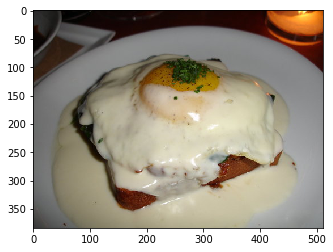

In [19]:
#y_train = np.load('y_train.npy')
#print(y_train[:10])
testimg = imread('Food-11/training/3_0.jpg')
print(testimg.shape)
plt.imshow(testimg)
#print(idx_to_type[4])

In [38]:
train_dir = os.listdir('Food-11/training')
num_train = len(train_dir)
val_dir = os.listdir('Food-11/validation')
num_val = len(val_dir)
test_dir = os.listdir('Food-11/evaluation')
num_test = len(test_dir)
print('num_train,num_val,num_test=',num_train,num_val,num_test)
asdf = np.uint8('10')
asdf

num_train,num_val,num_test= 9866 3430 3347


10

In [40]:
'''
indices = np.arange(num_train)
np.random.shuffle(indices)
x_train = np.empty((num_train,512,512,3), dtype=np.float32)
y_train = np.empty((num_train,), dtype=np.uint8)
for i in range(num_train):
    img_temp = imread('Food-11/training/'+train_dir[indices[i]])
    x_train[i,:img_temp.shape[0],:img_temp.shape[1],:img_temp.shape[2]] = img_temp[:512,:512,:]
    location = indices[i].find('/')
    y_train[i] = np.uint8(indices[i][:location])

plt.imshow(x_train[10])
print(y_train[:10])
'''


MemoryError: 

In [2]:
#testimg = imread('food-101/train/0.jpg')[:300,:300,:]
#print(testimg.shape)
#plt.imshow(testimg)



def train_generator(batch_size):
    num_batches = 0
    train_dir = os.listdir('Food-11/training')
    num_train = len(train_dir)
    indices = np.arange(num_train)
    np.random.shuffle(indices)
    while True:
        x_train = np.empty((batch_size,512,512,3), dtype=np.float32)
        y_train = np.empty((batch_size,), dtype=np.uint8)
        for i in range(batch_size):
            img_temp = imread('Food-11/training/'+train_dir[indices[batch_size*num_batches+i]])
            #print('food-101/train/{}.jpg'.format(batch_size*num_batches+i))
            x_train[i,:img_temp.shape[0],:img_temp.shape[1],:img_temp.shape[2]] = img_temp[:512,:512,:]
            location = train_dir[indices[batch_size*num_batches+i]].find('_')
            y_train[i] = np.uint8(train_dir[indices[batch_size*num_batches+i]][:location])
        num_batches = (num_batches+1) % (num_train//batch_size)
        #y_train = to_categorical(y_train,11)
        yield (x_train, y_train)

        

[10]
(512, 512, 3)


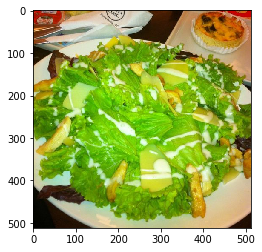

In [74]:
test = train_generator(1)
testimg, testlab = test.__next__()
testimg = testimg.astype(np.int32)

#n_classes = 101
#testlab = to_categorical(testlab, n_classes)

print(testlab)
print(testimg[0].shape)
plt.imshow(testimg[0])

In [3]:
def val_generator(batch_size):
    num_batches = 0
    val_dir = os.listdir('Food-11/validation')
    num_val = len(val_dir)
    indices = np.arange(num_val)
    np.random.shuffle(indices)
    while True:
        x_val = np.empty((batch_size,512,512,3), dtype=np.float32)
        y_val = np.empty((batch_size,), dtype=np.uint8)
        for i in range(batch_size):
            img_temp = imread('Food-11/training/'+val_dir[indices[batch_size*num_batches+i]])
            x_val[i,:img_temp.shape[0],:img_temp.shape[1],:img_temp.shape[2]] = img_temp[:512,:512,:]
            location = val_dir[indices[batch_size*num_batches+i]].find('_')
            y_val[i] = np.uint8(val_dir[indices[batch_size*num_batches+i]][:location])
        num_batches = (num_batches+1) % (num_val//batch_size)
        #y_val = to_categorical(y_val,11)
        yield (x_val, y_val)

[6 3]
(512, 512, 3)


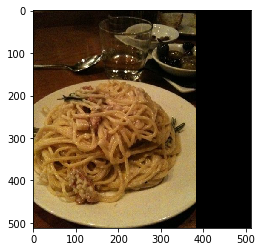

In [76]:
test = val_generator(2)
testimg, testlab = test.__next__()
testimg = testimg.astype(np.int32)

print(testlab)
print(testimg[0].shape)
plt.imshow(testimg[0])

In [5]:
BATCH_SIZE = 32
input_shape = (512,512,3)
num_classes = 11
#LEARNING_RATE = 1e-4
#opt = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = Sequential()
model.add(Conv2D(8, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator=train_generator(BATCH_SIZE),
                          steps_per_epoch = 9866//BATCH_SIZE,
                          epochs=10,
                          verbose=1,
                          validation_data=val_generator(100),
                          validation_steps = 10)

Epoch 1/10
308/308 [==============================] - 306s 992ms/step - loss: 13.6659 - acc: 0.1520 - val_loss: 13.7004 - val_acc: 0.1500
Epoch 2/10
308/308 [==============================] - 92s 300ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 14.0066 - val_acc: 0.1310
Epoch 3/10
308/308 [==============================] - 93s 302ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 13.6037 - val_acc: 0.1560
Epoch 4/10
308/308 [==============================] - 93s 301ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 13.7487 - val_acc: 0.1470
Epoch 5/10
308/308 [==============================] - 93s 302ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 13.9905 - val_acc: 0.1320
Epoch 6/10
308/308 [==============================] - 93s 303ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 13.4908 - val_acc: 0.1630
Epoch 7/10
308/308 [==============================] - 93s 302ms/step - loss: 13.6651 - acc: 0.1522 - val_loss: 13.8293 - val_acc: 0.1420
Epoch 8/10
308/308 [====================

2


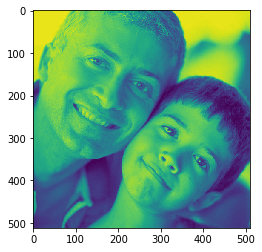

In [151]:
debug = imread('food-101/train/1250.jpg')
print(len(debug.shape))
plt.imshow(debug)